## Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
author: cdamien 2023

# BQ&A - Discord bot powered by LLM to answer questions on BigQuery datasets

@author: cdamien@google.com

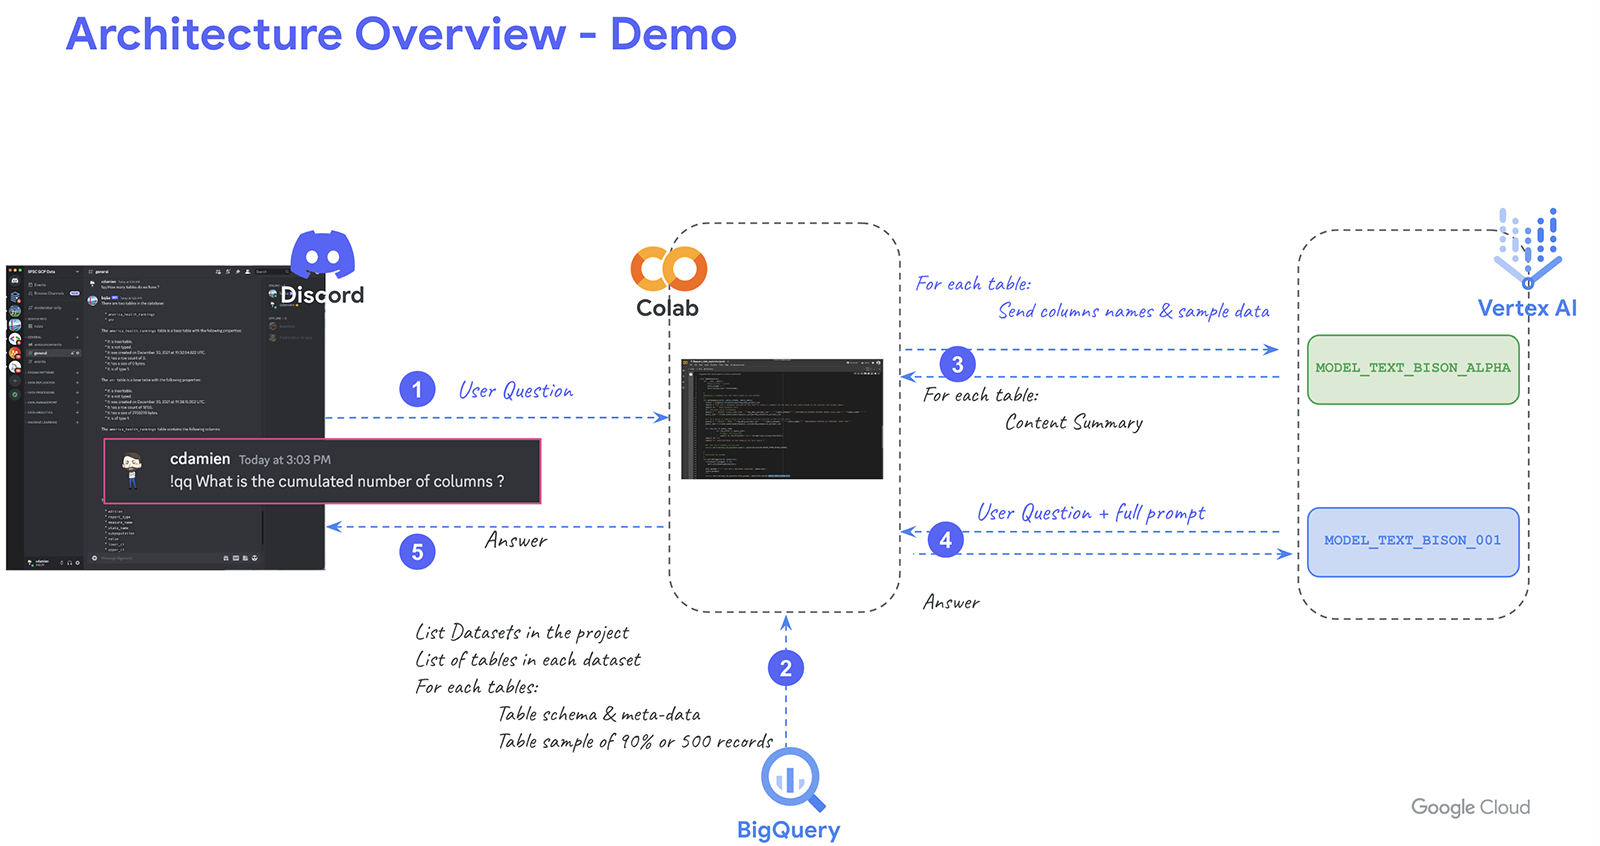

## Description
This colab demonstrates how to query summarize tabular data in BigQuery and ask question about the data using natural language via LLMs.

The motivation from this effort came from the fact that data discovery, wrangling and in general the understanding of the data can be very time consuming for Data Engineers, Data Analysts or anyone involved on the MLOps side.
* Identifying the relevant datasets: many companies have duplicates and local versions of the dataset where some part have been modified and are relevant for certain use cases but not other.
* Identifying the meaning of the data:
Many company don t have the discipline yet to leverage business meta data and therefore don't fully capture how data are generated, how they can be used, how they have been calculated or their meaning.
* understanding the content of the data: Data Quality, interpretation of the data, data volume as well as the fact that data can be siloed

This demo works by integrating as a bot in Discord and give you the ability to explore based on the schema information, data sampling, and a generated summary based on the content of the table.

## Data used in the demo
While the demo is made so that the user could ask for the list of projects he has access to and select one.
For the demo we limit the user to the content of the  bigquery-public-data
We also limit the volume of data to limit the prompt size.

## How to integrate with discord
- You need to create an application & a bot in your application
- use the TOKEN provided and add it to this colab
- make sure to execute one by one the different cell and restart the runtime when asked
- do not use the last cell as it is used to directly use in this colab

## How to use on discord side
This demo works by integrating as a bot in Discord where you can use the  following prompt

`!qq question `

to call our bq&a bot.


## How to test on colab side
You can test just by running the different cells in order but skiping the one for the discord bot

### Authenticate with your GCP user

In [2]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

## Packages Installation

In [2]:
# necessary to connect on the endpoint
!pip install google-cloud-aiplatform --upgrade

!pip install discord.py

#import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.3 MB/s eta 0:00:00


In [4]:
#@title Colab notebook variables { run: "auto", display-mode: "form" }
LLM_PROJECT_ID = '' #@param {type:"string"}
BQ_DATA_PROJECT_ID = "bigquery-public-data" #@param {type:"string"}
BQ_EXECUTION_PROJECT_ID = "" #@param {type:"string"}
REGION = "us-central1" #@param {type:"string"}
DISCORD_TOKEN = '' #@param {type:"string"}

### Get the full list of projects accessible by the user (not used in the demo)
function used to let user list up all the projects available to them and  be able to set it to get later information on the table contained

In [4]:
from google.cloud import resourcemanager_v3

def getListOfProjects():
  client = resourcemanager_v3.ProjectsClient()
  request = resourcemanager_v3.SearchProjectsRequest()
  page_result = client.search_projects(request=request)

  #working but should be used on a different org than google
  for response in page_result:
                result += "🗂️ " + response.parent + "/ 📁" + response.project_id +"\n"

### init





In [6]:
import logging
import re

from google.cloud import bigquery
import vertexai

from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict
from vertexai.preview.language_models import TextGenerationModel

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

#discord
import discord
from discord.ext import commands

aiplatform.init(project=LLM_PROJECT_ID, location=REGION)

#logging
logger= logging.getLogger('log')
logger.setLevel(logging.INFO)

# VertexAI wrapper updated for the preview
class VertexLLM:
    MODEL_TEXT_BISON_001 = "text-bison@001"
    MODEL_TEXT_BISON_ALPHA = "text-bison@alpha"

    def __init__(self, endpoint=REGION+"-aiplatform.googleapis.com", project=LLM_PROJECT_ID, location=REGION):
        self.client = aiplatform.gapic.PredictionServiceClient(client_options={"api_endpoint": endpoint})
        self.project = project
        self.location = location
        logger.info("init done")

    def predict(self, content, model=MODEL_TEXT_BISON_001, temp=0.4, max_tokens=1024, top_p=0.95, top_k=40, **kwargs):
        logger.info(content)

        llm_model = TextGenerationModel.from_pretrained(model)
        response = llm_model.predict(content,
        temperature=temp,
        max_output_tokens=max_tokens,
        top_k=top_k,
        top_p=top_p,
        )

        return response._prediction_response[0]

##testing Vertex connection
#vt = VertexLLM()
#vt.predict("How old is the earth ?", model=VertexLLM.MODEL_TEXT_BISON_001)




ModuleNotFoundError: ignored




### buildPrompt - Prompt preparation: project's datasets & tables

####What we do:
1. retrieve the list of datasets
2. for each dataset, extract the list of tables
3. for each table, extract information from the INFORMATION_SCHEMA view and __TABLES__
4. Append the information to the prompt and prepare to ask a question to BISON_001 model

###getSummary - Table Data Sampling & Summurisation (Bison_alpha)
What we do:
Query 1: extract from the table schema the list of columns
Query 2: retrieve a sample of 80% or 200 records which ever come first
combine columns and data to use in the prompt 4, prompt to generate a summary:bison_alpha model as it is good a summurisation



In [11]:

class BQAGenerator:
    def __init__(self):
        self.prompt = ""
        self.question = ""
        self.vertex_llm = VertexLLM()

    #
    #generate a summary for the table based on its content
    #
    def getSummary(self, table_schema, table_name):
      client = bigquery.Client(project=BQ_DATA_PROJECT_ID)
      result = "You are a database specialist and need to create a summary of the data in the table based on the content and column names:\n"
      result += "" #add examples here

      #0/ retrieve table fieldnames
      query1 = """SELECT column_name FROM `"""+BQ_DATA_PROJECT_ID+"""."""+table_schema+"""`.INFORMATION_SCHEMA.COLUMNS WHERE table_name ='"""+table_name+"""'"""
      query_job1 = client.query(query=query1, project=BQ_EXECUTION_PROJECT_ID)

      #1/ do a query to sample data from the table (max 200 records or 80% of the data)
      query2 = """SELECT * FROM `"""+BQ_DATA_PROJECT_ID+"""."""+table_schema+"""."""+table_name+"""` TABLESAMPLE SYSTEM (80 PERCENT) LIMIT 20"""
      query_job2 = client.query(query=query2, project=BQ_EXECUTION_PROJECT_ID)

      for row_val in query_job2:
                for row_field in query_job1:
                    #logger.info(row_val)
                    result += row_field[0]+":{}\n".format(row_val[row_field[0]])
                result += "\n"
      result += "\n"
      result += "question:What is the summary for this table ?"
      #logger.info(result)

      #3/ ask for a summary to our LLM limiting the length to 800 characters
      #return '{:.300}'.format(self.vertex_llm.predict(result, model=VertexLLM.MODEL_TEXT_BISON_001)['predictions'][0]['content'].replace('\n', '')) #we limit the output for the summary
      ## using preview
      return '{:.800}'.format(self.vertex_llm.predict(result.replace('"', '').replace("'", ""), model=VertexLLM.MODEL_TEXT_BISON_001)[0]['content'].replace('\n', '')) #we limit the output for the summary



    #
    # Building the prompt
    #
    def buildPrompt(self, question):
      if(len(self.prompt) == 0):
        logger.info("re generate")
        self.retrieveBigQueryInfo()
      else:
        logger.info("re-use")
      self.question = question
      full_prompt = f"""You are a database engineer, {question}:
      {self.prompt}
      """
      #logger.info("-->" + full_prompt)

      #validate result - we do few shots to guide the model toward giving an answer in percentage
      prediction = self.vertex_llm.predict(full_prompt, model=VertexLLM.MODEL_TEXT_BISON_001)

      #logger.info(prediction)

      #answer = prediction['predictions'][0]['content']
      #using preview
      answer = prediction[0]['content']

      # check if it is blocked
      is_blocked = False
      if prediction[0]['safetyAttributes']['blocked'] == "True":
        is_blocked = True

      # check if it is toxic / hate
      is_bad_content = False
      try:
        for x in prediction[0]['safetyAttributes']['scores']:
          if x > 0.7 and is_bad_content is False:
            is_bad_content = True
      except:
        print("No score in prediction")

      accuracy_prompt = "On a scale of 0 to 1, how good, appropriate and professional is the reply ? \n"
      accuracy_prompt += "question: How large is my dataset ? \n"
      accuracy_prompt += "reply: 40TB \n"
      accuracy_prompt += "answer: 90% \n \n"

      accuracy_prompt += "question: What are the tables containing healthcare data ? \n"
      accuracy_prompt += "reply: hospitals, patients, dentists, bycicles, coffee \n"
      accuracy_prompt += "answer: 60% \n \n"

      accuracy_prompt += "question: How many fields are in the table patients ? \n"
      accuracy_prompt += "there is 3 fields, fullname, age, email \n"
      accuracy_prompt += "answer: 99% \n \n"

      accuracy_prompt += "question:" + self.question + "\n"
      accuracy_prompt += "reply:" + answer + "\n"


      accuracy_result = self.vertex_llm.predict(accuracy_prompt, model=VertexLLM.MODEL_TEXT_BISON_001)[0]['content']
      #logger.info("results-->"+accuracy_result)

      accuracy_percent = re.findall(r'\d*%', accuracy_result)

      #logger.info("%-->"+accuracy_percent[0])
      is_not_pro = False
      try:
        if float(accuracy_percent[0].strip('%'))/100 < 0.7:
          is_not_pro = True
      except IndexError:
          logger.info("no % returned by model")



      #compare results
      if is_not_pro is True or is_blocked is True or is_bad_content is True :
          return  answer
      else:
          return "🤔" + answer

    def retrieveBigQueryInfo(self):
        #logger.info("starting----")
        self.prompt = ""
        client = bigquery.Client(project=BQ_DATA_PROJECT_ID)
        datasets = list(client.list_datasets())
        for dataset in datasets[:10]: # limiting to 1 table for testing
                dataset_name = client.get_dataset(dataset.dataset_id).dataset_id
                #logger.info("starting----"+ str(dataset_name) )
                query = """SELECT * FROM `"""+BQ_DATA_PROJECT_ID+"""."""+dataset_name+"""`.INFORMATION_SCHEMA.TABLES sc LEFT JOIN `"""+BQ_DATA_PROJECT_ID+"""."""+dataset_name+"""`.__TABLES__ st ON sc.table_name = st.table_id"""
                #logger.info(query)
                query_job = client.query(query=query, project=BQ_EXECUTION_PROJECT_ID)

                for row in query_job:
                  self.prompt += "table:{}.{}.{}\n".format(row['table_catalog'], row['table_schema'], row['table_name'])
                  #self.prompt  += "table_catalog:{}\n".format(row['table_catalog']) #dataset
                  #self.prompt += "table_schema:{}\n".format(row['table_schema'])
                  #self.prompt += "table_name:{}\n".format(row['table_name'])
                  self.prompt += "table_type:{}\n".format(row['table_type'])
                  #self.prompt += "is_insertable_into:{}\n".format(row['is_insertable_into'])
                  #self.prompt += "is_typed:{}\n".format(row['is_typed'])
                  self.prompt += "creation_time:{}\n".format(row['creation_time'])
                  self.prompt += "base_table:{}.{}.{}\n".format(row['base_table_catalog'], row['base_table_schema'], row['base_table_name'])
                  #self.prompt += "base_table_schema:{}\n".format()
                  #self.prompt += "base_table_name:{}\n".format(row['base_table_name'])
                  #self.prompt += "snapshot_time_ms:{}\n".format(row['snapshot_time_ms'])
                  if row['ddl'] is not None:
                    self.prompt += "ddl:{}\n".format(row['ddl'].replace('\n', '')) # some strange tables have no schema
                  #self.prompt +="default_collation_name:{}\n".format(row['default_collation_name'])
                  #self.prompt +="upsert_stream_apply_watermark:{}\n".format(row['upsert_stream_apply_watermark'])
                  #self.prompt +="project_id:{}\n".format(row['project_id'])
                  #self.prompt +="dataset_id:{}\n".format(row['dataset_id'])
                  #self.prompt +="table_id:{}\n".format(row['table_id'])
                  #self.prompt +="creation_time_1:{}\n".format(row['creation_time_1'])
                  self.prompt +="last_modified_time:{}\n".format(row['last_modified_time'])
                  self.prompt +="row_count:{}\n".format(row['row_count'])
                  self.prompt += "size_bytes:{}\n".format(row['size_bytes'])
                  #self.prompt +="type:{}\n".format(row['type'])
                  if row['table_type'] == "BASE TABLE" and row['row_count'] > 0:
                    self.prompt += "summary:" + self.getSummary(row['table_schema'], row['table_name']) + "\n"         # generate a summary of the data based on sample data
                  self.prompt += "\n"
        #logger.info(self.prompt)

### Discord Bot

In [ ]:
async def main():
  intents = discord.Intents.default()
  intents.message_content = True
  bot = commands.Bot(command_prefix='!',intents=intents)

  bqa = BQAGenerator()

  #main prompt
  @bot.command(name='qq')
  async def _qq(ctx, *, arg):
          if arg == "list projects":
              #await ctx.send( getListOfProjects()) # uncomment to activate
              await ctx.send(" 😢 : We are a lite version of the full BQ&A and that functionality has been disabled")
          elif arg == "list datasets":
             await ctx.send( getListOfDatasets()) # uncomment to activate
             await ctx.send(" 😢 : We are a lite version of the full BQ&A and that functionality has been disabled")
          elif arg == "help" or arg == '?':
              await ctx.send("type your question or 'help' or 'list projects' ")
          elif len(arg) > 0:
              client = bigquery.Client(project=BQ_DATA_PROJECT_ID)

              await ctx.send(bqa.buildPrompt(arg))
          else:
              await ctx.send("Lost in translation")

  # playful prompt
  @bot.command(name='imagine')
  async def _qq(ctx, *, arg):
        await ctx.send("I m not midJourney 🎈🎉")
  bot.run(DISCORD_TOKEN)

import nest_asyncio
nest_asyncio.apply()
await main()

Streaming output truncated to the last 5000 lines.
value:88.0
lower_ci:88.0
upper_ci:88.0
source:U.S. Census Bureau, American Community Survey PUMS
source_date:2015-2019

edition:2021
report_type:2021 Health Disparities
measure_name:Able-Bodied
state_name:West Virginia
subpopulation:None
value:77.0
lower_ci:76.0
upper_ci:77.0
source:U.S. Census Bureau, American Community Survey PUMS
source_date:2015-2019

edition:2021
report_type:2021 Health Disparities
measure_name:Able-Bodied
state_name:Arkansas
subpopulation:Female
value:78.0
lower_ci:78.0
upper_ci:79.0
source:U.S. Census Bureau, American Community Survey PUMS
source_date:2015-2019

edition:2021
report_type:2021 Health Disparities
measure_name:Able-Bodied
state_name:California
subpopulation:Female
value:87.0
lower_ci:87.0
upper_ci:87.0
source:U.S. Census Bureau, American Community Survey PUMS
source_date:2015-2019

edition:2021
report_type:2021 Health Disparities
measure_name:Able-Bodied
state_name:Colorado
subpopulation:Female
valu

### Colab testing
Use this cell if you want to test directly the result

In [12]:
#this is to test the whole process
bqa = BQAGenerator()
logger.info(bqa.buildPrompt("How many tables do we have ?")) # add your question here as a parameter


Streaming output truncated to the last 5000 lines.
footprint_length:None
footprint_width:None
notes:None
council_district:1
modified_date:2021-01-04 12:00:00+00:00

station_id:2538
name:Bullock Museum @ Congress & MLK
status:closed
address:1881 Congress Ave.
alternate_name:None
city_asset_number:None
property_type:None
number_of_docks:None
power_type:None
footprint_length:None
footprint_width:None
notes:None
council_district:1
modified_date:2021-01-04 12:00:00+00:00

station_id:2545
name:ACC - Rio Grande & 12th
status:closed
address:700 W. 12th St.
alternate_name:None
city_asset_number:None
property_type:None
number_of_docks:None
power_type:None
footprint_length:None
footprint_width:None
notes:None
council_district:9
modified_date:2021-01-04 12:00:00+00:00

station_id:2546
name:ACC - West & 12th Street
status:closed
address:1231 West Ave.
alternate_name:None
city_asset_number:None
property_type:None
number_of_docks:None
power_type:None
footprint_length:None
footprint_width:None
notes:N

InvalidArgument: ignored